In [45]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11646083724971645602
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5714739200
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16284234131985909250
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2d:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [46]:

class SatelliteDataset(tf.keras.utils.Sequence):
    def __init__(self, image_dir, label_dir, batch_size=32, image_size=(752, 752), shuffle=True):
        self.image_filenames = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
        self.label_filenames = [os.path.join(label_dir, x) for x in os.listdir(label_dir)]
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_files = [self.image_filenames[k] for k in indexes]
        label_files = [self.label_filenames[k] for k in indexes]
        return self.__generate_data(image_files, label_files)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_data(self, image_files, label_files):
        images = np.empty((self.batch_size, *self.image_size, 3))
        labels = np.empty((self.batch_size, *self.image_size, 1))
        for i, (img_file, label_file) in enumerate(zip(image_files, label_files)):
            img = tf.keras.preprocessing.image.load_img(img_file, target_size=self.image_size)
            label = tf.keras.preprocessing.image.load_img(label_file, target_size=self.image_size)
            label = np.where(np.array(label) == 255, 1, label)
            label = to_categorical(label, num_classes=2)
            images[i,] = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            labels[i,] = tf.keras.preprocessing.image.img_to_array(label) / 255.0
        return images, labels

# Define model architecture
model = models.Sequential([
    layers.Conv2D(64, 12, strides=4, padding='same', activation='relu', input_shape=(752, 752, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(112, 4, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(80, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(1, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(1, 16, strides=4, padding='same', activation='sigmoid')
])

# Compile the model
# model.compile(optimizer=optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])



model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Setup dataset generators
train_data = SatelliteDataset('C:\\Users\\sunda\\OneDrive\\Documents\\GitHub\COEN-6331\\Project\\MBDS\\png\\train', 'C:\\Users\\sunda\\OneDrive\\Documents\\GitHub\COEN-6331\\Project\\MBDS\\png\\train_labels', batch_size=32)
val_data = SatelliteDataset('C:\\Users\\sunda\\OneDrive\\Documents\\GitHub\COEN-6331\\Project\\MBDS\\png\\val', 'C:\\Users\\sunda\\OneDrive\\Documents\\GitHub\COEN-6331\\Project\\MBDS\\png\\val_labels', batch_size=32)
test_data = SatelliteDataset('C:\\Users\\sunda\\OneDrive\\Documents\\GitHub\COEN-6331\\Project\\MBDS\\png\\test', 'C:\\Users\\sunda\\OneDrive\\Documents\\GitHub\COEN-6331\\Project\\MBDS\\png\\test_labels', batch_size=1)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)


In [59]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [60]:
# Train the model
history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[reduce_lr])

ValueError: Unsupported image shape: (752, 752, 3, 2)

In [11]:
# Saving the Model
model.save('C:\\Users\\sunda\\OneDrive\\Documents\\GitHub\COEN-6331\\Project\\MBDS\\model(0.88).h5')

In [21]:
model.evaluate(test_data)

10/10 [==============================] - 1s 71ms/step - loss: 0.6933 - accuracy: 0.4804


[0.6932895183563232, 0.4803559184074402]

In [44]:
predictions = model.predict(test_data)

print(predictions)

10/10 [==============================] - 1s 71ms/step
[[[0.5003102 ]
  [0.50033617]
  [0.49978527]
  ...
  [0.50080216]
  [0.4995952 ]
  [0.5003933 ]]

 [[0.50017935]
  [0.5001987 ]
  [0.49983507]
  ...
  [0.49955812]
  [0.50039786]
  [0.49962127]]

 [[0.5001691 ]
  [0.4998082 ]
  [0.49959108]
  ...
  [0.50014913]
  [0.49973544]
  [0.49968782]]

 ...

 [[0.49994397]
  [0.49998188]
  [0.50002396]
  ...
  [0.49939787]
  [0.50002515]
  [0.5000413 ]]

 [[0.49999446]
  [0.49998236]
  [0.49991128]
  ...
  [0.5       ]
  [0.5       ]
  [0.5       ]]

 [[0.5000111 ]
  [0.5000461 ]
  [0.49998593]
  ...
  [0.5       ]
  [0.5       ]
  [0.5       ]]]


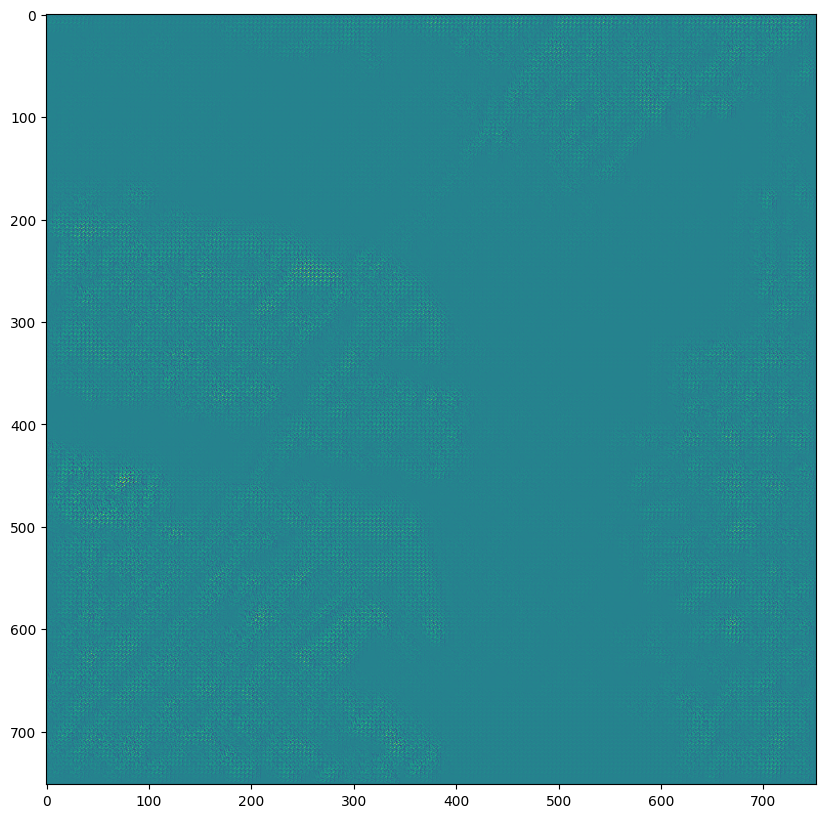

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(predictions[5, :, :, 0])
